<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Устранение-выбросов" data-toc-modified-id="Устранение-выбросов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Устранение выбросов</a></span></li><li><span><a href="#Борьба-с-пропусками" data-toc-modified-id="Борьба-с-пропусками-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Борьба с пропусками</a></span></li><li><span><a href="#Тип-данных" data-toc-modified-id="Тип-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Тип данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Решающее дерево</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак:
* Price — цена (евро)

## Подготовка данных

Загрузим нужные библиотеки.

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
warnings.filterwarnings('ignore')
import time

Прочитаем файл /datasets/autos.csv и сохраним его в переменную `auto`.

In [2]:
# читаем файл и сохраняем его в auto
auto = pd.read_csv('/datasets/autos.csv')

Напишем функцию, которая выводит общую информацию о таблице, а так же посчитает пропуски и проверит на наличие дубликатов.

In [3]:
#пишем функцию summary
def summary(df):
    print(df.info())
    display(df.head())
    count=0
    for col in df.columns:
        if df.isna().sum()[col]==0:
            count+=1
        else:
            print(f'Пропущенных значений в столбце {col}: {df.isna().sum()[col]}')
    if count==len(df.columns):
        print('Пропущенных значений в таблице нет')
    print(f'Повторов в таблице {df.duplicated().sum()}') 
    display(df.describe(percentiles=[.25,.5]))

In [4]:
# смотрим на данные таблицы
summary(auto)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Пропущенных значений в столбце VehicleType: 37490
Пропущенных значений в столбце Gearbox: 19833
Пропущенных значений в столбце Model: 19705
Пропущенных значений в столбце FuelType: 32895
Пропущенных значений в столбце NotRepaired: 71154
Повторов в таблице 4


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Итак есть данные о 354369 автомобилях. В 5 столбцах есть пропуски. Так же есть много категориальных столбцов, нужно их закодировать, для обучения модели. Так же можно заметить, что есть значения с 0 мощностью и 0 стоимостью автомобиля, такого быть не может. Для обучения модели, точно не понядобятся следующие столбцы: `DateCrawled`, `DateCreated`, `LastSeen`, `RegistrationMonth`, удалим их. Так же удалим столбец `NumberOfPictures`, так как он весь состоит из нулей.

In [5]:
# удаляем ненужные столбцы
auto = auto.drop(columns = ['DateCrawled','DateCreated','LastSeen','RegistrationMonth','NumberOfPictures'])

In [6]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
 10  PostalCode        354369 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Посмотрим, сколько строк с 0 ценой автомобиля.

In [7]:
# смотрим уникальные значения столбца
auto['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Прежде чем начнём устранять пропуски, изучим уникальные значения столбцов.

In [8]:
# смотрим уникальные значения столбца
auto['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [9]:
# смотрим уникальные значения столбца
auto['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [10]:
# смотрим уникальные значения столбца
auto['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [11]:
# смотрим уникальные значения столбца
auto['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

In [12]:
# смотрим уникальные значения столбца
auto['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [13]:
# смотрим уникальные значения столбца
auto['Kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

In [14]:
# смотрим уникальные значения столбца
auto['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [15]:
# смотрим уникальные значения столбца
auto['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [16]:
# смотрим уникальные значения столбца
auto['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [17]:
# смотрим уникальные значения столбца
auto['PostalCode'].unique()

array([70435, 66954, 90480, ..., 38528, 38325, 31096])

### Устранение выбросов

В столбце с ценой автомобиля есть 10772 строки с ценов = 0 евро. Такого быть не может. Так как это целевой признак, то удалим эти строки.

In [18]:
# удаляем строки с 0 ценой за автомобиль
auto = auto.query('Price > 0')

Посмотрим на распределение в столбце с ценой автомобиля.

[Text(0.5, 1.0, 'Цена автомобиля')]

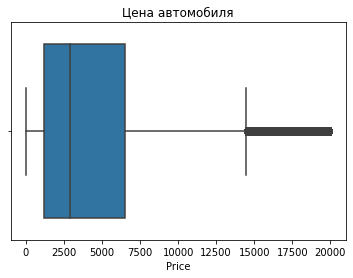

In [19]:
# строим диаграмму размаха для столбца 'Price'
sns.boxplot(x=auto['Price']).set(title='Цена автомобиля') 

Можно увидеть выбросы в районе 15000 евро. Однако, если посмотреть на столбец с брендами автомобилей, то такая цена уже не кажется выбросом. Ничего удалять не будем.

Посмотрим на распределение в столбце с годом регистрации.

In [20]:
# смотрим на распределение столбца 'RegistrationYear'
auto['RegistrationYear'].describe()

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Сразу заметны выбросы с min и max значениями. Установим интервал с 1950-го года до 2020-го года, т.к. автомобили, выпущенные ранее, врядли будут стоить 20000 евро( скорее даже в разы дороже).

In [21]:
# отсекаем выбросы в 'RegistrationYear'
auto = auto.query('1950 < RegistrationYear < 2020')

Text(0.5, 0, 'Год')

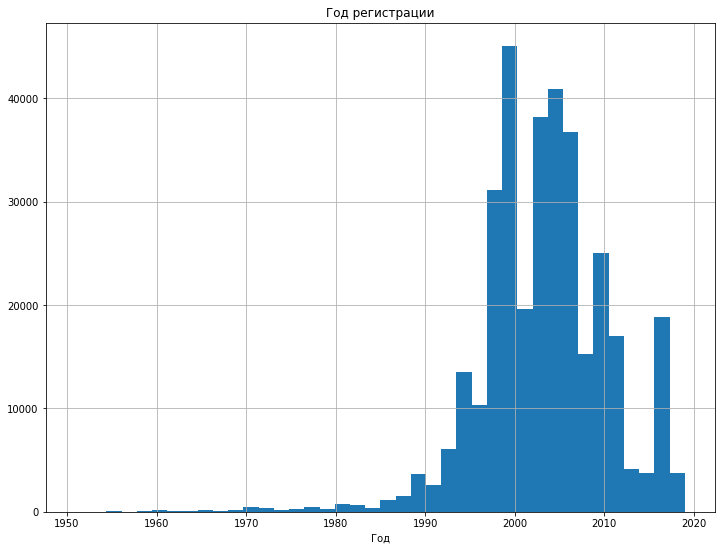

In [22]:
# посмотрим на распределение для столбца 'RegistrationYear'
auto['RegistrationYear'].hist(bins=40, figsize=(12,9))
plt.title('Год регистрации')
plt.xlabel("Год")

От выбросов избавились. По гистограмме видно, что основная масса автомобилей выпущена в период 1998 - 2008, с провалом в 2002 году.

Посмотрим на распределение в столбце с мощностью автомобиля.

In [23]:
auto['Power'].describe()

count    343315.000000
mean        111.014325
std         187.876435
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Мощность не может быть равна 0 л.с. и не может быть равной 20тыс.л.с.(это уже судовые двигатели). Можно установить max значение 1000 л.с., но это уже дорогие спорткары, их врядли будут продавать-покупать через мобильное приложение, да и стоить они будут значительно дороже 20000 евро. Установим максимальную мощность 350л.с., а минимальную 40л.с, так как это приложение расчитано на Европу, а в ней популярны малолитражки с компактными размерами, чтобы умещаться в узких старинных улочках.

In [24]:
# отсекаем выбросы в 'Power'
auto = auto.query('40 < Power < 350')

Столбец `Kilometer` на выбросы рассматривать не буду. Т.к. все по разному эксплуатируют автомобиль, то и средний годовой пробег у всех будет разный. К томуже влияет и срок эксплуатации.

### Борьба с пропусками

Посмотрим, сколько осталось пропусков, после удаления выбросов

In [25]:
# смотрим количество пропусков
auto.isna().sum()

Price                   0
VehicleType         21088
RegistrationYear        0
Gearbox              5921
Power                   0
Model               12019
Kilometer               0
FuelType            19469
Brand                   0
NotRepaired         46452
PostalCode              0
dtype: int64

In [26]:
# смотрим распределение по типу коробки передач
auto['Gearbox'].value_counts()

manual    238950
auto       59469
Name: Gearbox, dtype: int64

Преобладает МКПП. Заменим пропуски на 'manual', т.к. ориентируемся на Европейский рынок, а на нём в первую очередь будут смотреть на цену автомобиля. Автомобиль с МКПП будет стоить дешевле автомобиля с АКПП, да и в обслуживании дешевле.

In [27]:
auto.fillna({'Gearbox':'manual'}, inplace=True)

In [28]:
# смотрим распределение по типу топлива
auto['FuelType'].value_counts()

petrol      189988
gasoline     89333
lpg           4751
cng            499
hybrid         205
other           58
electric        37
Name: FuelType, dtype: int64

“Petrol” is used in mostly the UK and countries like India, Pakistan, Bangladesh, etc whereas “Gasoline” is used in United States and Canada. Это два разных обозначения одного и того же топлива. Правда нет разганичения на бензин и дизельное топливо( что плохо, учитывая принципиалные различия самих ДВС). Т.к. приложение для Европы, то заменим gasoline на petrol. lpg - это сжиженный газ, cng - компримированный природный газ, hybrid - значит автомобиль помимо ДВС имеет вспомогательную аккумуляторную батарею, electric - полностью электрический автомобиль. other - рискну предположить, что это либо автомобили, которые используют в качестве топлива водород, либо автомобили с солнечными батареями. Т.к. данные, скорее всего, выгружались несколько лет назад, то ещё не было сильного бума насчёт электромобилей. Заменим пропуски на жидкое топливо.

In [29]:
# заменяем 'gasoline' на 'petrol'
# заменяем пропуски на 'petrol'
auto['FuelType'] = auto['FuelType'].replace('gasoline', 'petrol')
auto.fillna({'FuelType':'petrol'}, inplace=True)

In [30]:
# смотрим распределение по наличию ремонта
auto['NotRepaired'].value_counts()

no     228437
yes     29451
Name: NotRepaired, dtype: int64

Т.к. сервис по продаже автомобилей с пробегом называется «Не бит, не крашен». То заменим пропуски на значени 'no'.

In [31]:
auto.fillna({'NotRepaired':'no'}, inplace=True)

Можно было бы закодировать категориальные признаки с помощью LabelEncoder или OneHotEncoder и тогда пропуски в столбцах с типом кузова и моделью авто можно было бы заполнять медианными значениями сгруппированными по бренду автомобиля и цене. Но одной из целью данного проекта является освоение пользования моделей LightGBM и CatBoost, а они могут работать с категориальными признаками. Заменим прпоуски в данных столбцах на 'unknown'.

In [32]:
# заменяем пропуски на unknown
auto.fillna({'VehicleType':'unknown', 'Model':'unknown'}, inplace=True)

### Тип данных

На данном этапе не будем кодировать категориальные признаки. Только сделаем замену столбцов Gearbox и NotRepaired на булев тип:
* IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
* IsNotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [33]:
# преобразуем в булев тип
auto['IsManualGearbox'] = 0
auto.loc[auto['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
auto.drop(['Gearbox'], inplace=True, axis=1)

In [34]:
# преобразуем в булев тип
auto['IsNotRepaired'] = 0
auto.loc[auto['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
auto.drop(['NotRepaired'], inplace=True, axis=1)

In [35]:
auto.head(5)

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,PostalCode,IsManualGearbox,IsNotRepaired
1,18300,coupe,2011,190,unknown,125000,petrol,audi,66954,1,1
2,9800,suv,2004,163,grand,125000,petrol,jeep,90480,0,0
3,1500,small,2001,75,golf,150000,petrol,volkswagen,91074,1,0
4,3600,small,2008,69,fabia,90000,petrol,skoda,60437,1,0
5,650,sedan,1995,102,3er,150000,petrol,bmw,33775,1,1


Изучим корреляцию между признаками.

In [36]:
corr = auto.corr()\
    .sort_values('Price', ascending=False)\
    .reset_index()
corr[['index', 'Price']].style.background_gradient('coolwarm')

,index,Price
0,Price,1.000000
1,Power,0.507547
2,RegistrationYear,0.439612
3,PostalCode,0.064034
4,IsNotRepaired,-0.191760
5,IsManualGearbox,-0.253345
6,Kilometer,-0.393301


На цену автомобиля влияют мощность и в меньшей степени год регистрации ТС. Так же влияет пробег автомобиля(обратная зависимость) - чем больше пробег, тем меньше цена.

**Вывод**
* были открыты и изучены данные о поддержаных автомобилях
* были удалены выбросы:
 * с годом регистрации авто ранее 1950-го года и позже 2020-го года
 * с мощностью автомоблия менее 40 л.с. и более 350 л.с.
* всего было удалено 50029 строк, что примерно составляет 14% от всех данных(это очень много, но оставшихся данных всё равно много)
* была произведена замена пропусков
* была сделана замена столбцов Gearbox и NotRepaired на булев тип
* была изучена корреляция признаков:
 * на цену автомобиля влияют мощность двигателя и год регистрации
 * обратное влияние оказывает пробег автомобиля

## Обучение моделей

Для обучения моделей, необходимо закодировать категориальные признаки. Но для модели CatBoostRegressor их кодировать не нужно.В качестве метрики для всех моделей будем использовать RMSE. Подготовим признаки для моделей и разобьём датафрейм на выборки.

In [37]:
# задаём признаки и целевой признак
# кодируем категориальные признаки

features = auto.drop('Price', axis=1)

encoder = OrdinalEncoder()
cat_columns = ['VehicleType','Model', 'FuelType','Brand']
cat_features = features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]
    
target = auto['Price']

In [38]:
# разбиваем датасет на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

ordinal_features_train = ordinal_features.loc[features_train.index, :]
ordinal_features_test = ordinal_features.loc[features_test.index, :]

### CatBoostRegressor

Обучим модель CatBoostRegressor

In [39]:
%%time

Cat = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['VehicleType','Model', 'FuelType','Brand']) 
cv_RMSE_CBR = (cross_val_score(Cat,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE_CatBoostRegressor =', cv_RMSE_CBR)

RMSE_CatBoostRegressor = 1639.1657805222574
CPU times: user 2min 5s, sys: 835 ms, total: 2min 5s
Wall time: 2min 8s


### LGBMRegressor

In [40]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'n_estimators': range (1, 15, 2), 
                'max_depth': range (1, 15, 2),
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Лучшие параметры:

{'max_depth': 11, 'n_estimators': 13, 'random_state': 12345}

4419.161891 for {'max_depth': 1, 'n_estimators': 1, 'random_state': 12345}
4192.158171 for {'max_depth': 1, 'n_estimators': 3, 'random_state': 12345}
4020.185118 for {'max_depth': 1, 'n_estimators': 5, 'random_state': 12345}
3874.865833 for {'max_depth': 1, 'n_estimators': 7, 'random_state': 12345}
3752.227908 for {'max_depth': 1, 'n_estimators': 9, 'random_state': 12345}
3647.561764 for {'max_depth': 1, 'n_estimators': 11, 'random_state': 12345}
3557.121635 for {'max_depth': 1, 'n_estimators': 13, 'random_state': 12345}
4307.952307 for {'max_depth': 3, 'n_estimators': 1, 'random_state': 12345}
3892.925925 for {'max_depth': 3, 'n_estimators': 3, 'random_state': 12345}
3553.338003 for {'max_depth': 3, 'n_estimators': 5, 'random_state': 12345}
3289.412438 for {'max_depth': 3, 'n_estimators': 7, 'random_state': 12345}
3074.337425 for {'max_depth': 3, 'n_estimators': 9, 'random_state': 12345}
2900.064929 for {

### Решающее дерево

In [41]:
%%time

regressor = DecisionTreeRegressor() 
hyperparams = [{'max_depth':range (1, 25, 2),
                'min_samples_leaf': range (1, 25, 2),
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Лучшие параметры:

{'max_depth': 19, 'min_samples_leaf': 11, 'random_state': 12345}

3734.166323 for {'max_depth': 1, 'min_samples_leaf': 1, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 3, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 5, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 7, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 9, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 11, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 13, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 15, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 17, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 19, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_samples_leaf': 21, 'random_state': 12345}
3734.166323 for {'max_depth': 1, 'min_sa

## Анализ моделей

Из 3-х обученных моделей лучшее значение RMSE получили у CatBoostRegressor. У неё же наилучшее значение по быстроте расчётов. Но при этом нужно отметить, что гиперпараметров у неё задавалось меньше. У модели LGBMRegressor значение RMSE хуже и считает она дольше. Хуже всех значение RMSE у модели Решающего дерева и считает она дольше всех.

In [42]:
%%time
best_model = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['VehicleType','Model', 'FuelType','Brand']) 
best_model.fit(features_train, target_train)
test_predictions = best_model.predict(features_test)
print("RMSE:", mean_squared_error(target_test, test_predictions) ** 0.5)

RMSE: 1628.9113027867174
CPU times: user 30.4 s, sys: 199 ms, total: 30.6 s
Wall time: 31.1 s


 Разница в 1%